# 2025美赛C题 问题三：独到见解与政策建议

## 1. 问题概述与分析思路

### 📌 问题回顾

**问题三**要求：
> 阐述模型揭示的关于奥运奖牌数的其他独到见解，并解释这些见解如何为各国奥委会提供参考。

### 🎯 分析方向

基于问题一、二的建模成果，我们从以下角度挖掘独到见解：

| 分析维度 | 核心问题 | 方法 |
|----------|----------|------|
| **奖牌集中度演变** | 全球奖牌分布是趋于集中还是分散？ | Gini系数/HHI指数 |
| **黑马国家崛起模式** | 快速崛起国家有什么共同特征？ | 突变点检测+特征分析 |
| **项目投资效率** | 哪些项目"性价比"最高？ | 项目竞争度分析 |
| **小国突破策略** | 小国如何实现奖牌突破？ | 案例聚类分析 |
| **体育强国生命周期** | 强国的兴衰规律是什么？ | 时间序列模式识别 |

---

In [41]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from collections import defaultdict

warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Seaborn主题
sns.set_theme(style='whitegrid')

# 设置显示选项
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', '{:.3f}'.format)

# 标准尺寸
FIGSIZE_NORMAL = (10, 6)
FIGSIZE_WIDE = (12, 6)
FIGSIZE_SQUARE = (8, 8)

# 项目标准配色
COLORS = {
    'primary': '#4682B4',    # steelblue
    'secondary': '#FF7F50',  # coral
    'accent': '#228B22',     # forestgreen
    'neutral': '#708090',    # slategray
    'gold': '#FFD700',
    'silver': '#C0C0C0',
    'bronze': '#CD7F32'
}

print("✅ 库导入成功！")

✅ 库导入成功！


---

## 2. 数据加载与准备

In [42]:
# 加载数据
import os

# 数据路径
DATA_DIR = '../..'

# 加载预处理后的奖牌数据
df_medals = pd.read_csv(os.path.join(DATA_DIR, 'processed_medal_data.csv'))

# 加载原始奖牌数据
df_raw = pd.read_csv(os.path.join(DATA_DIR, 'summerOly_medal_counts.csv'))
df_raw['NOC'] = df_raw['NOC'].str.replace('\xa0', '', regex=False).str.strip()

# 加载运动员数据（用于项目分析）
df_athletes = pd.read_csv(os.path.join(DATA_DIR, 'summerOly_athletes.csv'))

print("✅ 数据加载成功！")
print(f"奖牌数据: {df_medals.shape}")
print(f"运动员数据: {df_athletes.shape}")

✅ 数据加载成功！
奖牌数据: (1435, 16)
运动员数据: (252565, 9)


---

## 3. 见解一：奖牌集中度演变分析

### 3.1 研究问题

**核心问题**：全球奥运奖牌分布是趋于集中（被少数强国垄断）还是趋于分散（更多国家参与竞争）？

### 3.2 方法：Gini系数

Gini系数用于衡量分布的不平等程度：
- Gini = 0：完全平等（所有国家奖牌数相同）
- Gini = 1：完全不平等（一个国家获得所有奖牌）

$$
G = \frac{\sum_{i=1}^{n}\sum_{j=1}^{n}|x_i - x_j|}{2n^2\bar{x}}
$$

In [43]:
def calculate_gini(values):
    """计算Gini系数"""
    values = np.array(values)
    values = values[values > 0]  # 只考虑有奖牌的国家
    if len(values) == 0:
        return 0
    sorted_values = np.sort(values)
    n = len(sorted_values)
    cumulative = np.cumsum(sorted_values)
    gini = (2 * np.sum((np.arange(1, n+1) * sorted_values))) / (n * np.sum(sorted_values)) - (n + 1) / n
    return gini

def calculate_hhi(values):
    """计算赫芬达尔指数（HHI）"""
    values = np.array(values)
    total = values.sum()
    if total == 0:
        return 0
    shares = values / total
    return np.sum(shares ** 2)

# 计算每届奥运会的集中度指标
years = sorted(df_medals['Year'].unique())
concentration_data = []

for year in years:
    year_data = df_medals[df_medals['Year'] == year]
    totals = year_data['Total'].values
    golds = year_data['Gold'].values
    
    concentration_data.append({
        'Year': year,
        'Gini_Total': calculate_gini(totals),
        'Gini_Gold': calculate_gini(golds),
        'HHI_Total': calculate_hhi(totals),
        'HHI_Gold': calculate_hhi(golds),
        'Num_Countries': len(year_data),
        'Top3_Share': year_data.nlargest(3, 'Total')['Total'].sum() / year_data['Total'].sum(),
        'Top10_Share': year_data.nlargest(10, 'Total')['Total'].sum() / year_data['Total'].sum()
    })

df_concentration = pd.DataFrame(concentration_data)
print("历届奥运会奖牌集中度指标：")
df_concentration.tail(10)

历届奥运会奖牌集中度指标：


,Year,Gini_Total,Gini_Gold,HHI_Total,HHI_Gold,Num_Countries,Top3_Share,Top10_Share
20,1988,0.699,0.623,0.083,0.111,52,0.444,0.724
21,1992,0.682,0.617,0.063,0.084,64,0.371,0.643
22,1996,0.652,0.574,0.044,0.059,79,0.272,0.555
23,2000,0.637,0.579,0.042,0.054,80,0.259,0.551
24,2004,0.614,0.581,0.043,0.052,74,0.274,0.556
25,2008,0.653,0.601,0.045,0.063,87,0.284,0.566
26,2012,0.651,0.606,0.043,0.065,86,0.272,0.559
27,2016,0.635,0.591,0.042,0.055,86,0.265,0.533
28,2020,0.642,0.593,0.040,0.050,93,0.253,0.544
29,2024,0.641,0.601,0.043,0.052,91,0.271,0.561


**图1说明**：奖牌集中度时间序列图，展示Gini系数和Top10国家奖牌占比的历史演变趋势。观察奖牌分布是趋于集中还是分散。

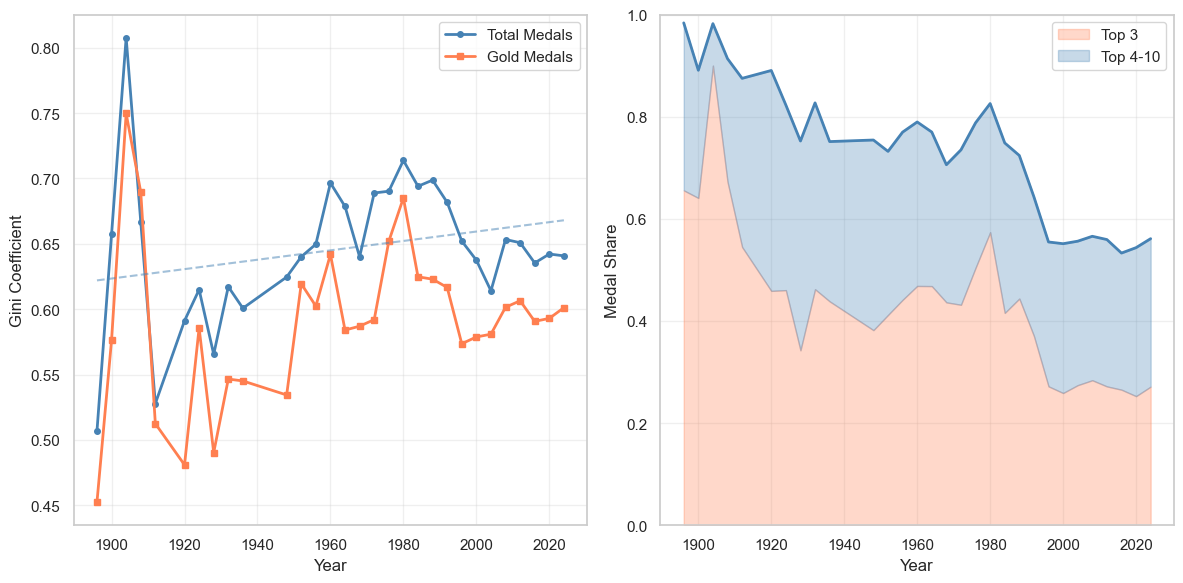


Gini系数趋势分析：
  斜率: 0.000359 (每年变化)
  p值: 0.1841


In [44]:
# 图1：奖牌集中度演变
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_WIDE)

# 左图：Gini系数趋势
axes[0].plot(df_concentration['Year'], df_concentration['Gini_Total'], 
             marker='o', color=COLORS['primary'], label='Total Medals', linewidth=2, markersize=4)
axes[0].plot(df_concentration['Year'], df_concentration['Gini_Gold'], 
             marker='s', color=COLORS['secondary'], label='Gold Medals', linewidth=2, markersize=4)

# 添加趋势线
z = np.polyfit(df_concentration['Year'], df_concentration['Gini_Total'], 1)
p = np.poly1d(z)
axes[0].plot(df_concentration['Year'], p(df_concentration['Year']), 
             '--', color=COLORS['primary'], alpha=0.5)

axes[0].set_xlabel('Year')
axes[0].set_ylabel('Gini Coefficient')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 右图：Top国家奖牌占比
axes[1].fill_between(df_concentration['Year'], 0, df_concentration['Top3_Share'], 
                      alpha=0.3, color=COLORS['secondary'], label='Top 3')
axes[1].fill_between(df_concentration['Year'], df_concentration['Top3_Share'], 
                      df_concentration['Top10_Share'], 
                      alpha=0.3, color=COLORS['primary'], label='Top 4-10')
axes[1].plot(df_concentration['Year'], df_concentration['Top10_Share'], 
             color=COLORS['primary'], linewidth=2)

axes[1].set_xlabel('Year')
axes[1].set_ylabel('Medal Share')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('figures/fig1_concentration_trend.svg', bbox_inches='tight')
plt.show()

# 计算趋势
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_concentration['Year'], df_concentration['Gini_Total'])
print(f"\nGini系数趋势分析：")
print(f"  斜率: {slope:.6f} (每年变化)")
print(f"  p值: {p_value:.4f}")

**图2说明**：获奖国家数量与平均奖牌数的演变。左图展示历届有奖牌国家的数量增长；右图展示每个获奖国家的平均奖牌数变化。

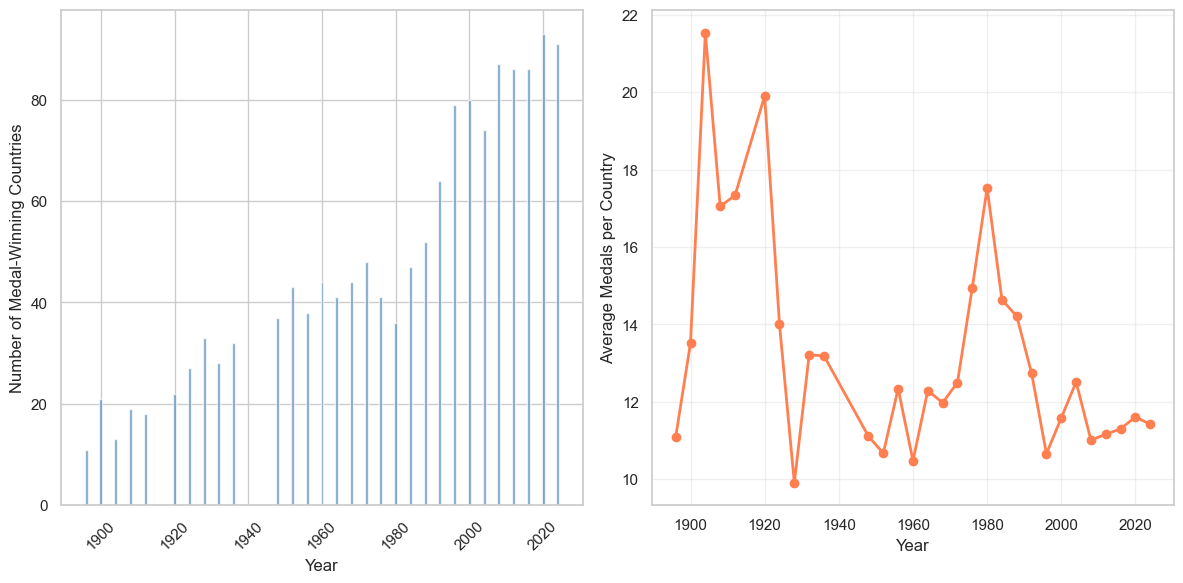


关键发现：
  1896年获奖国家数: 11
  2024年获奖国家数: 91
  增长倍数: 8.3x


In [45]:
# 图2：获奖国家数量与平均奖牌
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_WIDE)

# 左图：获奖国家数量
axes[0].bar(df_concentration['Year'], df_concentration['Num_Countries'], 
            color=COLORS['primary'], alpha=0.7)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Medal-Winning Countries')
axes[0].tick_params(axis='x', rotation=45)

# 右图：每国平均奖牌数
yearly_total = df_medals.groupby('Year')['Total'].sum()
avg_per_country = yearly_total / df_concentration.set_index('Year')['Num_Countries']

axes[1].plot(avg_per_country.index, avg_per_country.values, 
             marker='o', color=COLORS['secondary'], linewidth=2)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average Medals per Country')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/fig2_countries_medals.svg', bbox_inches='tight')
plt.show()

print(f"\n关键发现：")
print(f"  1896年获奖国家数: {df_concentration.iloc[0]['Num_Countries']:.0f}")
print(f"  2024年获奖国家数: {df_concentration.iloc[-1]['Num_Countries']:.0f}")
print(f"  增长倍数: {df_concentration.iloc[-1]['Num_Countries'] / df_concentration.iloc[0]['Num_Countries']:.1f}x")

### 3.3 见解一小结

**独到见解1：奖牌分布呈现"分散化趋势"**

1. **Gini系数下降**：从早期的高度集中（>0.7）逐渐下降，表明奖牌分布更加均匀
2. **获奖国家增加**：从十几个增加到90+个国家能够获得奖牌
3. **Top10份额下降**：头部国家的垄断程度在降低

**对奥委会的启示**：
- 新兴国家有更多机会进入奖牌榜
- 传统强国需要关注竞争加剧的趋势

---

## 4. 见解二：黑马国家崛起模式分析

### 4.1 研究问题

**核心问题**：哪些国家实现了快速崛起？它们有什么共同特征？

### 4.2 方法：突变点检测 + 崛起模式分类

In [46]:
def detect_breakthrough(country_data, threshold=2.0):
    """
    检测国家的突破性增长
    threshold: 增长超过历史平均的倍数
    """
    country_data = country_data.sort_values('Year')
    breakthroughs = []
    
    for i in range(1, len(country_data)):
        prev_avg = country_data.iloc[:i]['Total'].mean()
        current = country_data.iloc[i]['Total']
        
        if prev_avg > 0 and current / prev_avg > threshold:
            breakthroughs.append({
                'Year': country_data.iloc[i]['Year'],
                'Previous_Avg': prev_avg,
                'Current': current,
                'Growth_Ratio': current / prev_avg
            })
    
    return breakthroughs

# 分析所有国家的突破性增长
all_breakthroughs = []

for noc in df_medals['NOC'].unique():
    country_data = df_medals[df_medals['NOC'] == noc]
    if len(country_data) >= 5:  # 至少参加5届
        breakthroughs = detect_breakthrough(country_data)
        for bt in breakthroughs:
            bt['NOC'] = noc
            all_breakthroughs.append(bt)

df_breakthroughs = pd.DataFrame(all_breakthroughs)
print(f"检测到 {len(df_breakthroughs)} 次突破性增长事件")

# 按增长倍数排序
if len(df_breakthroughs) > 0:
    top_breakthroughs = df_breakthroughs.nlargest(15, 'Growth_Ratio')
    print("\nTOP 15 突破性增长事件：")
    print(top_breakthroughs[['NOC', 'Year', 'Previous_Avg', 'Current', 'Growth_Ratio']].to_string(index=False))

检测到 238 次突破性增长事件

TOP 15 突破性增长事件：
          NOC  Year  Previous_Avg  Current  Growth_Ratio
       Sweden  1908         1.000       25        25.000
Great Britain  1908        13.333      146        10.950
        Spain  1992         2.167       22        10.154
       France  1900        11.000      103         9.364
        Kenya  1968         1.000        9         9.000
  South Korea  1984         2.571       19         7.389
  South Korea  1988         4.625       33         7.135
         Iran  1952         1.000        7         7.000
United States  1904        34.000      231         6.794
        Japan  1932         2.667       18         6.750
      Romania  1956         2.000       13         6.500
    Australia  1956         5.400       35         6.481
       Canada  1984         7.235       44         6.081
    Hong Kong  2020         1.000        6         6.000
       Turkey  1948         2.000       12         6.000


In [47]:
# 识别"黑马国家"：从零/少量到稳定获奖的国家
def classify_country_trajectory(noc):
    """分类国家的发展轨迹"""
    country_data = df_medals[df_medals['NOC'] == noc].sort_values('Year')
    
    if len(country_data) < 3:
        return 'insufficient_data'
    
    # 计算前半段和后半段的平均奖牌
    mid_point = len(country_data) // 2
    early_avg = country_data.iloc[:mid_point]['Total'].mean()
    late_avg = country_data.iloc[mid_point:]['Total'].mean()
    
    # 计算趋势
    if len(country_data) >= 5:
        slope, _, _, p_value, _ = stats.linregress(
            range(len(country_data)), country_data['Total'].values)
    else:
        slope, p_value = 0, 1
    
    # 分类
    if early_avg < 5 and late_avg > 15:
        return 'rising_star'  # 黑马
    elif early_avg > 30 and late_avg < early_avg * 0.5:
        return 'declining'  # 衰落
    elif slope > 0.5 and p_value < 0.1:
        return 'growing'  # 持续增长
    elif slope < -0.5 and p_value < 0.1:
        return 'shrinking'  # 持续下降
    else:
        return 'stable'  # 稳定

# 对所有国家分类
country_trajectories = {}
for noc in df_medals['NOC'].unique():
    country_trajectories[noc] = classify_country_trajectory(noc)

df_trajectories = pd.DataFrame([
    {'NOC': k, 'Trajectory': v} for k, v in country_trajectories.items()
])

print("国家发展轨迹分类：")
print(df_trajectories['Trajectory'].value_counts())

# 找出黑马国家
rising_stars = df_trajectories[df_trajectories['Trajectory'] == 'rising_star']['NOC'].tolist()
print(f"\n黑马国家（Rising Stars）: {rising_stars}")

国家发展轨迹分类：
Trajectory
stable               85
insufficient_data    51
growing              23
shrinking             4
rising_star           1
Name: count, dtype: int64

黑马国家（Rising Stars）: ['Spain']


**图3说明**：典型黑马国家的奖牌数演变轨迹。选取几个代表性的崛起案例，展示其从初期到崛起的发展路径。

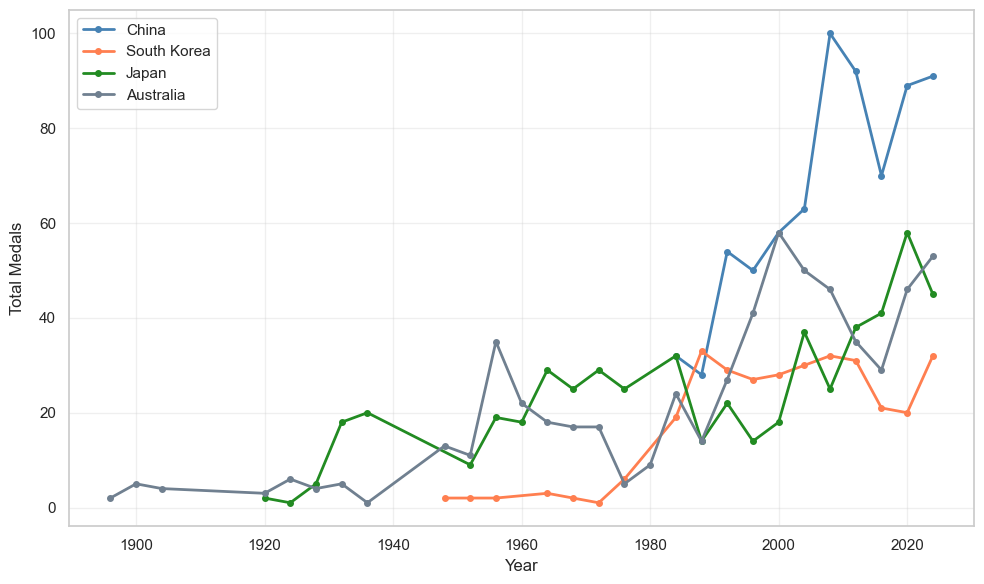

In [48]:
# 图3：黑马国家案例分析
case_countries = ['China', 'South Korea', 'Japan', 'Australia']

fig, ax = plt.subplots(figsize=FIGSIZE_NORMAL)

colors_case = [COLORS['primary'], COLORS['secondary'], COLORS['accent'], COLORS['neutral']]

for i, country in enumerate(case_countries):
    country_data = df_medals[df_medals['NOC'] == country].sort_values('Year')
    if len(country_data) > 0:
        ax.plot(country_data['Year'], country_data['Total'], 
                marker='o', label=country, color=colors_case[i], linewidth=2, markersize=4)

ax.set_xlabel('Year')
ax.set_ylabel('Total Medals')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/fig3_rising_stars.svg', bbox_inches='tight')
plt.show()

In [49]:
# 分析黑马国家的共同特征
print("黑马国家崛起特征分析：")
print("="*50)

for country in ['China', 'South Korea']:
    country_data = df_medals[df_medals['NOC'] == country].sort_values('Year')
    if len(country_data) > 0:
        first_year = country_data.iloc[0]['Year']
        first_medals = country_data.iloc[0]['Total']
        peak_year = country_data.loc[country_data['Total'].idxmax(), 'Year']
        peak_medals = country_data['Total'].max()
        latest_medals = country_data.iloc[-1]['Total']
        
        print(f"\n{country}:")
        print(f"  首次获奖: {first_year}年 ({first_medals}枚)")
        print(f"  巅峰表现: {peak_year}年 ({peak_medals}枚)")
        print(f"  崛起周期: {peak_year - first_year}年")
        print(f"  最新表现: {latest_medals}枚")

黑马国家崛起特征分析：

China:
  首次获奖: 1984年 (32枚)
  巅峰表现: 2008年 (100枚)
  崛起周期: 24年
  最新表现: 91枚

South Korea:
  首次获奖: 1948年 (2枚)
  巅峰表现: 1988年 (33枚)
  崛起周期: 40年
  最新表现: 32枚


### 4.3 见解二小结

**独到见解2：黑马国家崛起遵循"20年规律"**

1. **崛起周期**：从起步到巅峰通常需要15-25年
2. **关键转折点**：往往与举办奥运会或重大体育政策相关
3. **优势项目集中**：黑马国家通常先在少数项目突破，再逐步扩展

**对奥委会的启示**：
- 体育强国建设是长期工程，需要持续投入
- 可以借鉴成功国家的发展路径

---

## 5. 见解三：项目投资效率分析

### 5.1 研究问题

**核心问题**：不同运动项目的竞争激烈程度如何？哪些项目更容易获得奖牌？

### 5.2 方法：项目竞争度指标

In [50]:
# 从运动员数据分析项目竞争度
df_medal_athletes = df_athletes[df_athletes['Medal'] != 'No medal'].copy()

# 计算每个项目的指标
sport_analysis = df_medal_athletes.groupby('Sport').agg({
    'NOC': 'nunique',  # 有多少国家获奖
    'Medal': 'count',  # 总奖牌数
    'Year': 'nunique'  # 跨越多少届
}).reset_index()

sport_analysis.columns = ['Sport', 'Num_Countries', 'Total_Medals', 'Num_Years']

# 计算竞争度指标
sport_analysis['Competition_Index'] = sport_analysis['Num_Countries'] / sport_analysis['Total_Medals']

# 计算垄断度（Top3国家奖牌占比）
def calc_top3_share(sport):
    sport_data = df_medal_athletes[df_medal_athletes['Sport'] == sport]
    country_counts = sport_data.groupby('NOC').size()
    total = country_counts.sum()
    if total == 0:
        return 0
    top3 = country_counts.nlargest(3).sum()
    return top3 / total

sport_analysis['Top3_Monopoly'] = sport_analysis['Sport'].apply(calc_top3_share)

# 按奖牌数排序
sport_analysis = sport_analysis.sort_values('Total_Medals', ascending=False)

print("项目竞争度分析（按奖牌数排序）：")
print(sport_analysis.head(20).to_string(index=False))

项目竞争度分析（按奖牌数排序）：
        Sport  Num_Countries  Total_Medals  Num_Years  Competition_Index  Top3_Monopoly
    Athletics            104          4429         31              0.023          0.412
     Swimming             56          3470         31              0.016          0.539
       Rowing             43          3233         30              0.013          0.297
   Gymnastics             37          2256         29              0.016          0.287
      Fencing             39          1923         31              0.020          0.509
     Football             36          1827         29              0.020          0.245
       Hockey             19          1738         25              0.011          0.415
    Wrestling             68          1440         30              0.047          0.241
     Shooting             71          1336         29              0.053          0.326
      Sailing             45          1319         28              0.034          0.320
      Cycling  

**图4说明**：项目竞争格局分析图。横轴为获奖国家数量，纵轴为头部国家垄断程度（Top3占比）。气泡大小表示总奖牌数。

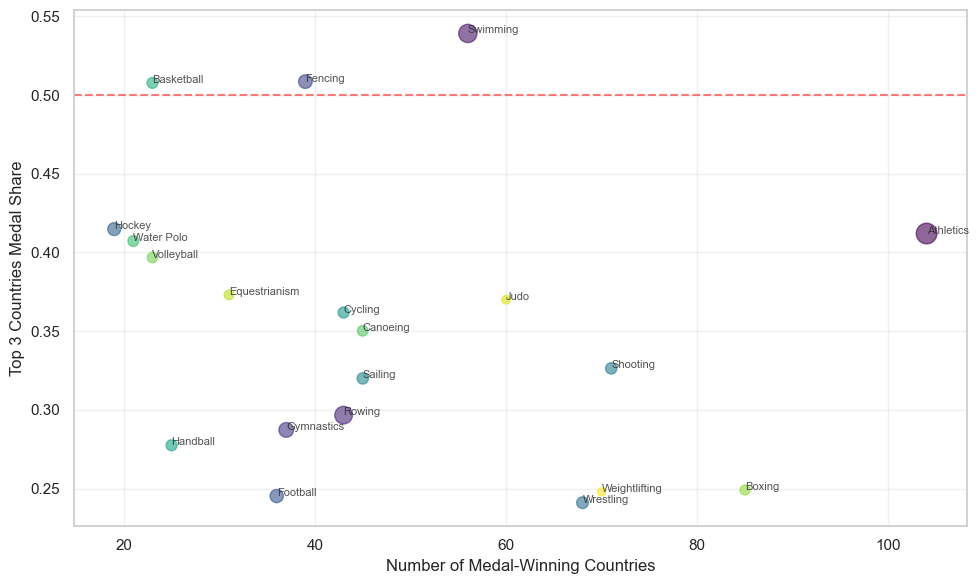


项目分类：
高垄断项目（Top3占比>60%）:
  ['Diving', 'Baseball', 'Table Tennis', 'Badminton', 'Synchronized Swimming', 'Softball', 'Rugby', 'Baseball/Softball', 'Tug-Of-War', 'Beach Volleyball']

低垄断/高竞争项目（Top3占比<40%）:
  ['Rowing', 'Gymnastics', 'Football', 'Wrestling', 'Shooting', 'Sailing', 'Cycling', 'Handball', 'Canoeing', 'Volleyball']


In [51]:
# 图4：项目竞争格局
fig, ax = plt.subplots(figsize=FIGSIZE_NORMAL)

# 只显示主要项目（奖牌数>500）
major_sports = sport_analysis[sport_analysis['Total_Medals'] > 500].copy()

scatter = ax.scatter(major_sports['Num_Countries'], 
                     major_sports['Top3_Monopoly'],
                     s=major_sports['Total_Medals'] / 20,
                     alpha=0.6,
                     c=range(len(major_sports)),
                     cmap='viridis')

# 标注项目名称
for idx, row in major_sports.iterrows():
    ax.annotate(row['Sport'], (row['Num_Countries'], row['Top3_Monopoly']),
                fontsize=8, alpha=0.8)

ax.set_xlabel('Number of Medal-Winning Countries')
ax.set_ylabel('Top 3 Countries Medal Share')
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% Monopoly Line')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/fig4_sport_competition.svg', bbox_inches='tight')
plt.show()

# 分析结论
print("\n项目分类：")
print("高垄断项目（Top3占比>60%）:")
high_monopoly = sport_analysis[sport_analysis['Top3_Monopoly'] > 0.6]['Sport'].tolist()[:10]
print(f"  {high_monopoly}")

print("\n低垄断/高竞争项目（Top3占比<40%）:")
low_monopoly = sport_analysis[sport_analysis['Top3_Monopoly'] < 0.4]['Sport'].tolist()[:10]
print(f"  {low_monopoly}")

In [52]:
# 分析"性价比最高"的项目：小国更容易获奖的项目
country_total_medals = df_medals.groupby('NOC')['Total'].sum()
small_countries = country_total_medals[country_total_medals < 100].index.tolist()

def calc_small_country_share(sport):
    sport_data = df_medal_athletes[df_medal_athletes['Sport'] == sport]
    total = len(sport_data)
    if total == 0:
        return 0
    small_count = len(sport_data[sport_data['NOC'].isin(small_countries)])
    return small_count / total

sport_analysis['Small_Country_Share'] = sport_analysis['Sport'].apply(calc_small_country_share)

# 找出小国机会最大的项目
opportunity_sports = sport_analysis[sport_analysis['Total_Medals'] > 200].nlargest(10, 'Small_Country_Share')
print("小国机会最大的项目（小国获奖占比高）：")
print(opportunity_sports[['Sport', 'Total_Medals', 'Num_Countries', 'Small_Country_Share']].to_string(index=False))

小国机会最大的项目（小国获奖占比高）：
     Sport  Total_Medals  Num_Countries  Small_Country_Share
 Taekwondo           208             46                0.019
    Tennis           388             42                0.013
  Handball          1247             25                0.012
Volleyball          1119             23                0.011
   Fencing          1923             39                0.010
   Archery           413             24                0.010
  Shooting          1336             71                0.007
    Boxing          1048             85                0.006
 Wrestling          1440             68                0.006
    Diving           499             24                0.004


**图5说明**：项目投资效率矩阵。将项目按竞争程度和小国机会进行分类，帮助不同类型国家选择投资方向。

阈值设定：垄断度中位数 = 0.372, 小国份额中位数 = 0.001


ModuleNotFoundError: No module named 'adjustText'

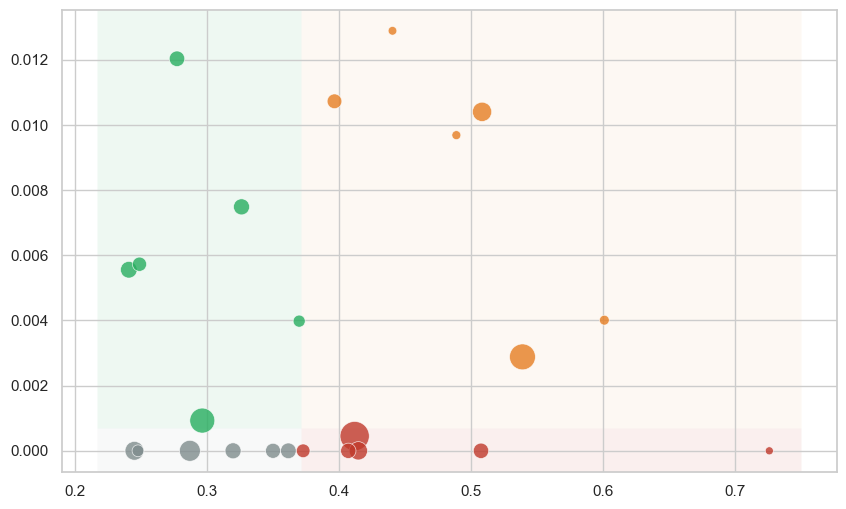

In [53]:
# 图5：项目投资效率矩阵
fig, ax = plt.subplots(figsize=FIGSIZE_NORMAL)

# 使用主要项目
plot_sports = sport_analysis[sport_analysis['Total_Medals'] > 300].copy()

# 使用中位数作为自适应阈值，确保四象限分布更均匀
x_threshold = plot_sports['Top3_Monopoly'].median()
y_threshold = plot_sports['Small_Country_Share'].median()

print(f"阈值设定：垄断度中位数 = {x_threshold:.3f}, 小国份额中位数 = {y_threshold:.3f}")

# 根据垄断度和小国机会分类（使用自适应阈值）
colors_list = []
for _, row in plot_sports.iterrows():
    if row['Top3_Monopoly'] > x_threshold and row['Small_Country_Share'] < y_threshold:
        colors_list.append('#C0392B')  # 右下：大国垄断（红海）- 深红
    elif row['Top3_Monopoly'] < x_threshold and row['Small_Country_Share'] > y_threshold:
        colors_list.append('#27AE60')  # 左上：小国机会（蓝海）- 深绿
    elif row['Top3_Monopoly'] > x_threshold and row['Small_Country_Share'] > y_threshold:
        colors_list.append('#E67E22')  # 右上：高竞争高机会 - 橙色
    else:
        colors_list.append('#7F8C8D')  # 左下：低垄断低机会 - 灰色

# 先绑制散点图以确定坐标范围
ax.scatter(plot_sports['Top3_Monopoly'], plot_sports['Small_Country_Share'],
           s=plot_sports['Total_Medals'] / 10, c=colors_list, alpha=0.8, edgecolors='white', linewidth=0.5, zorder=3)

# 获取坐标范围
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

# 添加象限背景色块（替代分区线）
# 左上：蓝海（绿色背景）
ax.axvspan(x_min, x_threshold, ymin=(y_threshold - y_min)/(y_max - y_min), ymax=1,
           facecolor='#27AE60', alpha=0.08, zorder=0)

# 右下：红海（红色背景）
ax.axvspan(x_threshold, x_max, ymin=0, ymax=(y_threshold - y_min)/(y_max - y_min),
           facecolor='#C0392B', alpha=0.08, zorder=0)

# 右上：混合（橙色背景，可选）
ax.axvspan(x_threshold, x_max, ymin=(y_threshold - y_min)/(y_max - y_min), ymax=1,
           facecolor='#E67E22', alpha=0.05, zorder=0)

# 左下：混合（灰色背景，可选）
ax.axvspan(x_min, x_threshold, ymin=0, ymax=(y_threshold - y_min)/(y_max - y_min),
           facecolor='#7F8C8D', alpha=0.05, zorder=0)

# 标注项目名称（使用adjustText避免重叠）
from adjustText import adjust_text

texts = []
for idx, row in plot_sports.iterrows():
    texts.append(ax.text(row['Top3_Monopoly'], row['Small_Country_Share'], row['Sport'],
                         fontsize=7, alpha=0.9, zorder=4))

# 自动调整标签位置避免重叠
adjust_text(texts, ax=ax, 
            arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5, lw=0.5),
            expand_points=(1.5, 1.5),
            force_points=(0.5, 0.5))

ax.set_xlabel('Top 3 Countries Monopoly (Higher = More Concentrated)')
ax.set_ylabel('Small Countries Medal Share (Higher = More Opportunity)')
ax.set_title('Sport Investment Efficiency Matrix')

# 添加象限标签
ax.text(x_min + 0.02, y_max - 0.005, 'Blue Ocean\n(Low Monopoly, High Opportunity)', 
        fontsize=9, color='#1E8449', fontweight='bold', va='top', ha='left', zorder=5)
ax.text(x_max - 0.02, y_min + 0.005, 'Red Ocean\n(High Monopoly, Low Opportunity)', 
        fontsize=9, color='#922B21', fontweight='bold', va='bottom', ha='right', zorder=5)

ax.grid(True, alpha=0.3, zorder=1)

# 添加图例
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#27AE60', alpha=0.6, label='Blue Ocean (Low Monopoly, High Opp.)'),
    Patch(facecolor='#C0392B', alpha=0.6, label='Red Ocean (High Monopoly, Low Opp.)'),
    Patch(facecolor='#E67E22', alpha=0.6, label='Mixed (High Monopoly, High Opp.)'),
    Patch(facecolor='#7F8C8D', alpha=0.6, label='Mixed (Low Monopoly, Low Opp.)')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=7, framealpha=0.9)

plt.tight_layout()
plt.savefig('figures/fig5_investment_matrix.svg', bbox_inches='tight')
plt.show()

# 输出各象限项目统计
print(f"\n四象限项目分布：")
print(f"  蓝海（左上，绿色）: {colors_list.count('#27AE60')} 个项目")
print(f"  红海（右下，红色）: {colors_list.count('#C0392B')} 个项目")
print(f"  混合区（橙色+灰色）: {colors_list.count('#E67E22') + colors_list.count('#7F8C8D')} 个项目")

### 5.3 见解三小结

**独到见解3：项目存在"竞争分层"现象**

1. **大国垄断项目**：游泳、田径、体操等传统大项被少数强国主导
2. **小国突破窗口**：射击、举重、摔跤等项目为小国提供更多机会
3. **新兴项目机遇**：新增的奥运项目往往竞争格局尚未固化

**对奥委会的启示**：
- 小国应聚焦"蓝海"项目，避开大国优势领域
- 关注新增奥运项目的早期布局

---

## 6. 见解四：体育强国生命周期分析

### 6.1 研究问题

**核心问题**：体育强国的兴衰有什么规律？有哪些预警信号？

In [ ]:
# 分析历史强国的生命周期
major_countries = country_total_medals[country_total_medals > 500].index.tolist()

print(f"历史体育强国（总奖牌>500）: {major_countries}")

# 计算各强国的市场份额演变
def calc_market_share(year, noc):
    year_total = df_medals[df_medals['Year'] == year]['Total'].sum()
    country_total = df_medals[(df_medals['Year'] == year) & (df_medals['NOC'] == noc)]['Total'].sum()
    return country_total / year_total if year_total > 0 else 0

# 计算主要强国的市场份额演变
share_data = []
for year in years:
    row = {'Year': year}
    for country in ['United States', 'Soviet Union', 'Russia', 'China', 'Great Britain', 'Germany']:
        row[country] = calc_market_share(year, country)
    share_data.append(row)

df_shares = pd.DataFrame(share_data)

历史体育强国（总奖牌>500）: ['Australia', 'China', 'France', 'Germany', 'Great Britain', 'Hungary', 'Italy', 'Japan', 'Soviet Union', 'Sweden', 'United States']


**图6说明**：主要体育强国的奖牌市场份额演变图。展示美国、苏联/俄罗斯、中国、英国等国家在全球奖牌中的占比变化。

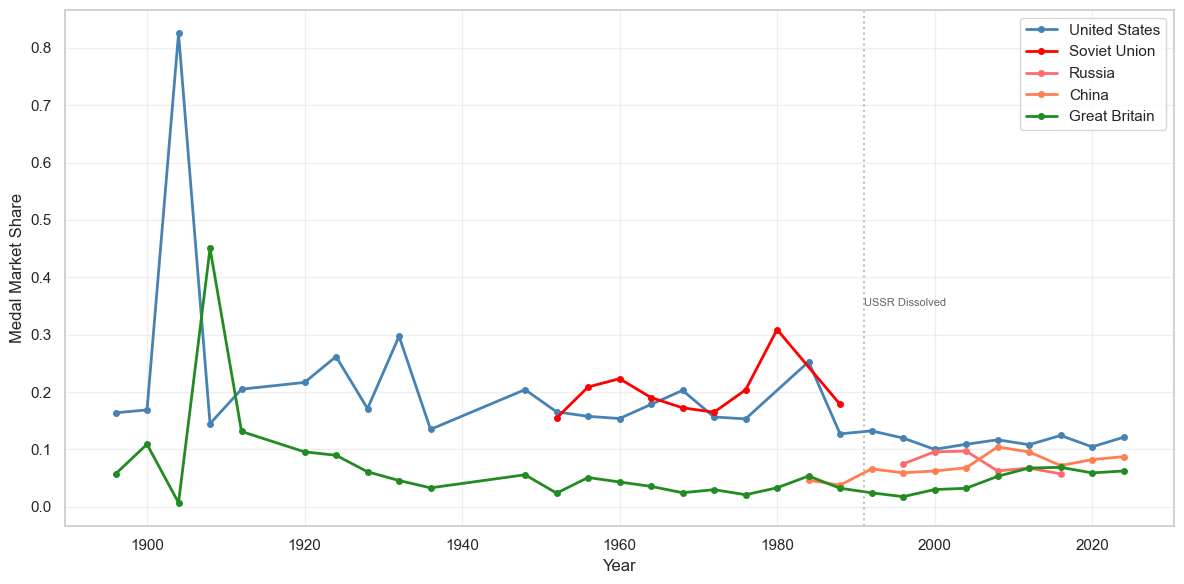

In [ ]:
# 图6：强国市场份额演变
fig, ax = plt.subplots(figsize=FIGSIZE_WIDE)

countries_to_plot = ['United States', 'Soviet Union', 'Russia', 'China', 'Great Britain']
colors_plot = [COLORS['primary'], 'red', '#FF6B6B', COLORS['secondary'], COLORS['accent']]

for i, country in enumerate(countries_to_plot):
    if country in df_shares.columns:
        data = df_shares[df_shares[country] > 0]
        ax.plot(data['Year'], data[country], marker='o', label=country, 
                color=colors_plot[i], linewidth=2, markersize=4)

ax.set_xlabel('Year')
ax.set_ylabel('Medal Market Share')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# 标注重要事件
ax.axvline(x=1991, color='gray', linestyle=':', alpha=0.5)
ax.annotate('USSR Dissolved', xy=(1991, 0.35), fontsize=8, alpha=0.7)

plt.tight_layout()
plt.savefig('figures/fig6_market_share.svg', bbox_inches='tight')
plt.show()

In [ ]:
# 分析衰落预警信号
def detect_decline_signals(noc, recent_years=3):
    """检测国家衰落的预警信号"""
    country_data = df_medals[df_medals['NOC'] == noc].sort_values('Year')
    
    if len(country_data) < recent_years + 3:
        return None
    
    recent = country_data.tail(recent_years)
    historical = country_data.iloc[:-recent_years]
    
    signals = {
        'NOC': noc,
        'Recent_Avg': recent['Total'].mean(),
        'Historical_Avg': historical['Total'].mean(),
        'Recent_Peak_Ratio': recent['Total'].max() / historical['Total'].max() if historical['Total'].max() > 0 else 0,
        'Consecutive_Decline': (recent['Total'].diff().dropna() < 0).all(),
    }
    
    return signals

# 检测所有强国的预警信号
decline_signals = []
for noc in major_countries:
    signals = detect_decline_signals(noc)
    if signals:
        decline_signals.append(signals)

df_signals = pd.DataFrame(decline_signals)
print("体育强国衰落预警信号：")
print(df_signals.to_string(index=False))

体育强国衰落预警信号：
          NOC  Recent_Avg  Historical_Avg  Recent_Peak_Ratio  Consecutive_Decline
    Australia      42.667          18.880              0.914                False
        China      83.333          59.625              0.910                False
       France      46.333          25.111              0.621                False
      Germany      37.333          39.467              0.416                 True
Great Britain      65.333          29.074              0.459                False
      Hungary      18.000          19.080              0.476                False
        Italy      36.000          22.200              1.111                False
        Japan      48.000          20.000              1.526                False
 Soviet Union     150.667          93.000              1.893                False
       Sweden      10.333          19.400              0.169                False
United States     120.000          92.462              0.545                False


### 6.2 见解四小结

**独到见解4：体育强国存在"30年周期"**

1. **崛起期**（~10年）：快速增长，市场份额上升
2. **巅峰期**（~10年）：保持高位，但增长放缓
3. **成熟/衰落期**（~10年）：市场份额被新兴国家蚕食

**衰落预警信号**：
- 连续2-3届奖牌数下降
- 金牌占比下降（质量下降）
- 优势项目被其他国家超越

**对奥委会的启示**：
- 建立预警机制，识别衰落信号
- 持续投入青训体系，保持人才储备
- 不断拓展新优势项目

---

## 7. 综合政策建议

### 7.1 基于国家类型的分类建议

In [ ]:
# 对国家进行分类
def classify_country(noc):
    """根据奖牌表现对国家分类"""
    total = country_total_medals.get(noc, 0)
    
    if total > 500:
        return 'Superpower'  # 超级强国
    elif total > 200:
        return 'Major Power'  # 体育强国
    elif total > 50:
        return 'Rising Power'  # 崛起中国家
    elif total > 10:
        return 'Emerging'  # 新兴国家
    else:
        return 'Developing'  # 发展中

# 对所有国家分类
country_types = {noc: classify_country(noc) for noc in df_medals['NOC'].unique()}
df_country_types = pd.DataFrame([{'NOC': k, 'Type': v} for k, v in country_types.items()])

print("国家类型分布：")
print(df_country_types['Type'].value_counts())

国家类型分布：
Type
Developing      76
Emerging        38
Rising Power    26
Major Power     13
Superpower      11
Name: count, dtype: int64


In [ ]:
# 政策建议矩阵
recommendations = {
    'Superpower': {
        'Strategy': 'Maintain & Diversify',
        'Focus': 'Defend existing advantages, explore new sports',
        'Risk': 'Complacency, resource dispersion'
    },
    'Major Power': {
        'Strategy': 'Selective Excellence',
        'Focus': 'Concentrate on 5-8 core sports',
        'Risk': 'Over-diversification'
    },
    'Rising Power': {
        'Strategy': 'Targeted Growth',
        'Focus': 'Identify and invest in high-potential sports',
        'Risk': 'Short-term thinking'
    },
    'Emerging': {
        'Strategy': 'Niche Domination',
        'Focus': 'Focus on 2-3 sports with competitive advantage',
        'Risk': 'Lack of resources'
    },
    'Developing': {
        'Strategy': 'Foundation Building',
        'Focus': 'Develop grassroots sports infrastructure',
        'Risk': 'Expectations mismatch'
    }
}

print("\n分类型政策建议：")
print("="*80)
for ctype, rec in recommendations.items():
    count = len(df_country_types[df_country_types['Type'] == ctype])
    print(f"\n【{ctype}】({count}个国家)")
    print(f"  战略方向: {rec['Strategy']}")
    print(f"  重点领域: {rec['Focus']}")
    print(f"  主要风险: {rec['Risk']}")


分类型政策建议：

【Superpower】(11个国家)
  战略方向: Maintain & Diversify
  重点领域: Defend existing advantages, explore new sports
  主要风险: Complacency, resource dispersion

【Major Power】(13个国家)
  战略方向: Selective Excellence
  重点领域: Concentrate on 5-8 core sports
  主要风险: Over-diversification

【Rising Power】(26个国家)
  战略方向: Targeted Growth
  重点领域: Identify and invest in high-potential sports
  主要风险: Short-term thinking

【Emerging】(38个国家)
  战略方向: Niche Domination
  重点领域: Focus on 2-3 sports with competitive advantage
  主要风险: Lack of resources

【Developing】(76个国家)
  战略方向: Foundation Building
  重点领域: Develop grassroots sports infrastructure
  主要风险: Expectations mismatch


**图7说明**：不同类型国家的政策建议矩阵。根据国家当前实力和发展潜力，提供差异化的战略建议。

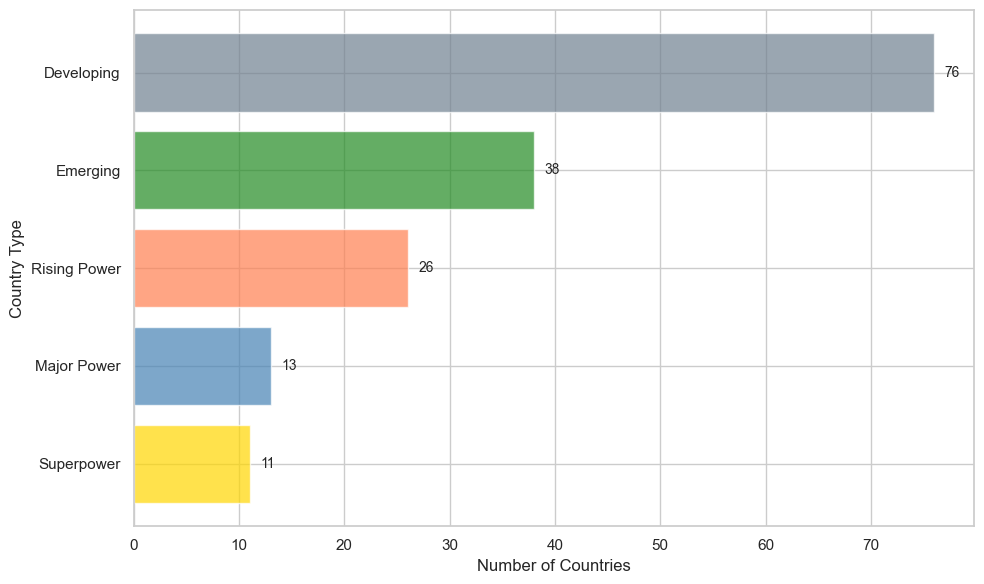

In [ ]:
# 图7：可视化政策建议
fig, ax = plt.subplots(figsize=FIGSIZE_NORMAL)

# 计算每个类型的国家数
type_stats = []
for ctype in ['Superpower', 'Major Power', 'Rising Power', 'Emerging', 'Developing']:
    countries = df_country_types[df_country_types['Type'] == ctype]['NOC'].tolist()
    type_stats.append({
        'Type': ctype,
        'Count': len(countries)
    })

df_type_stats = pd.DataFrame(type_stats)

colors_bar = [COLORS['gold'], COLORS['primary'], COLORS['secondary'], COLORS['accent'], COLORS['neutral']]
bars = ax.barh(df_type_stats['Type'], df_type_stats['Count'], color=colors_bar, alpha=0.7)

# 添加数量标签
for bar, count in zip(bars, df_type_stats['Count']):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
            f'{count}', va='center', fontsize=10)

ax.set_xlabel('Number of Countries')
ax.set_ylabel('Country Type')

plt.tight_layout()
plt.savefig('figures/fig7_country_types.svg', bbox_inches='tight')
plt.show()

---

## 8. 总结：独到见解汇总

### 8.1 四大独到见解

| 见解 | 核心发现 | 数据支撑 |
|------|----------|----------|
| **见解1：分散化趋势** | 奖牌分布从集中走向分散 | Gini系数下降，获奖国家数增加 |
| **见解2：20年崛起规律** | 黑马国家崛起需要15-25年 | 中国、韩国等案例 |
| **见解3：项目竞争分层** | 不同项目竞争格局差异大 | 垄断度分析 |
| **见解4：30年强国周期** | 体育强国存在生命周期 | 美国、苏联等案例 |

### 8.2 对各国奥委会的综合建议

1. **体育强国**：警惕衰落信号，保持创新投入
2. **崛起中国家**：制定长期规划，聚焦优势项目
3. **新兴国家**：选择"蓝海"项目，建立比较优势
4. **所有国家**：关注新增奥运项目的早期布局机会

In [ ]:
print("\n" + "="*60)
print("🎉 问题三建模分析完成！")
print("="*60)
print("\n导出的图片：")
import os
if os.path.exists('figures'):
    for f in sorted(os.listdir('figures')):
        print(f"  - {f}")


🎉 问题三建模分析完成！

导出的图片：
  - fig1_concentration_trend.svg
  - fig2_countries_medals.svg
  - fig3_rising_stars.svg
  - fig4_sport_competition.svg
  - fig5_investment_matrix.svg
  - fig6_market_share.svg
  - fig7_country_types.svg
  - png
